# CS 439 Final Project - Disease Prediction ML Model


In [1]:
#!pip install pandas requests pyreadstat

In [2]:
import numpy as np
import pandas as pd
import pyreadstat
import requests
import re

## Data Processing

### Fetching the data

We are using data from NHANES (National Health and Nutrition Examination Survey). We are going to gather data that enacapsulates a wider range than traditional models, specifically data that isn't obviously medical related.

links can be found at [https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?Cycle=2021-2023](https://)

In [3]:
from typing import ByteString
from io import BytesIO

def load_xpt(url):
  response = requests.get(url)
  if response.status_code != 200:
    raise Exception(f'failed to download {url}')
  return pd.read_sas(BytesIO(response.content), format='xport')

#base_url = 'https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/'
base_url = 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/'

urls = {
    'Demographics': base_url + 'DEMO_L.XPT',
    'Medical Conditions': base_url + 'MCQ_L.XPT',
    'Diabetes': base_url + 'DIQ_L.XPT',
    'Hypertension': base_url + 'BPQ_L.XPT',
    'Prescription Meds': base_url + 'RXQ_RX_L.XPT',
    'Plasma glucose': base_url + 'GLU_L.XPT',
    'CBC': base_url + 'CBC_L.XPT',
    'Body Measures': base_url + 'BMX_L.XPT',
    'Immunization': base_url + 'IMQ_L.XPT',
    'Physical Activity': base_url + 'PAQ_L.XPT',
    'Alchohol Use': base_url + 'ALQ_L.XPT',
    'Smoking': base_url + 'SMQ_L.XPT',
    'Diet': base_url + 'DBQ_L.XPT',
    'Health Insurance': base_url + 'HIQ_L.XPT',
    'Housing': base_url + 'HOQ_L.XPT',
    'Income and Food Security': base_url + 'INQ_L.XPT',
    'Pesticide Use': base_url + 'PUQMEC_L.XPT',
    'Occupational': base_url + 'OCQ_L.XPT',
    'Glycohemoglobin': base_url + 'GHB_L.XPT',
    'Oscillometric BP': base_url + 'BPXO_L.XPT'
}

data = {} # dictionary with keys = dataset names and values = DataFrames
for name, url in urls.items():
  try:
    data[name] = load_xpt(url)
    print(f'loaded {name}')
  except Exception as e:
    print(f'Failed to load {name} : {e}')

df = data['Demographics'] # merging all datasets into 1 master df, starting with demographics
for key in data:
  if key != 'Demographics':
    df = df.merge(data[key], on='SEQN', how='left')

# 20 datasets

loaded Demographics
loaded Medical Conditions
loaded Diabetes
loaded Hypertension
loaded Prescription Meds
loaded Plasma glucose
loaded CBC
loaded Body Measures
loaded Immunization
loaded Physical Activity
loaded Alchohol Use
loaded Smoking
loaded Diet
loaded Health Insurance
loaded Housing
loaded Income and Food Security
loaded Pesticide Use
loaded Occupational
loaded Glycohemoglobin
loaded Oscillometric BP


In [4]:
# checking which dataeet contain the DIQ010 col (variable from the diabetes module)
for name, df_mod in data.items():
    if 'DIQ010' in df_mod.columns:
        print(f'{name} has DIQ010')

Diabetes has DIQ010


In [5]:
print(df["DIQ010"].value_counts(dropna=False)) # how often each value appears in the DIQ010 col

# 1 --> yes
# 2 --> no
# 3 --> borderlin3
# 9 --> don't know

DIQ010
2.0    10371
1.0     1081
3.0      284
NaN      193
9.0        4
Name: count, dtype: int64


### Explore the Data

In [6]:
print(len(set(df.columns)))
print(set(df.columns))
print(f"Final merged shape: {df.shape}")
df.head()


211
{'DMDBORN4', 'DMDHSEDZ', 'HIQ032I', 'IND310', 'RIAGENDR', 'DBQ330', 'BMIARML', 'BMDSTATS', 'IMQ060', 'HIQ032B', 'MCQ160L', 'MCQ170M', 'IMQ070', 'DBQ073U', 'RIDSTATR', 'RIDEXMON', 'LBXMCVSI', 'BPQ080', 'DMQMILIZ', 'BMIWAIST', 'LBXMOPCT', 'DID060', 'DBQ370', 'RIDAGEMN', 'BMXLEG', 'DMDHRGND', 'ALQ280', 'MCQ510F', 'DIQ010', 'LBDLYMNO', 'DBD041', 'ALQ111', 'HIQ210', 'MCQ160P', 'MCQ170L', 'RIDRETH1', 'LBXHCT', 'BMXRECUM', 'MCQ560', 'DBQ360', 'DBQ424', 'PUQ110', 'BMXHIP', 'BMIRECUM', 'RIDEXAGM', 'BMIHEAD', 'IMQ011', 'SMD641', 'DBQ421', 'LBXPLTSI', 'MCQ053', 'BMIARMC', 'LBXGH', 'ALQ142', 'HIQ032A', 'LBXRBCSI', 'RIDEXPRG', 'BMXARML', 'DBD030', 'HIQ032H', 'LBXMCHSI', 'LBXHGB', 'DIQ070', 'LBXEOPCT', 'BPXOSY1', 'BMDBMIC', 'OCD150', 'MCQ040', 'MCQ195', 'PAD680', 'LBDGLUSI', 'SDMVSTRA', 'PAD790U', 'HIQ032E', 'BPXODI2', 'DBD381', 'DMDHRMAZ', 'DBQ073D', 'DMDEDUC2', 'SDMVPSU', 'BPQ101D', 'LBXWBCSI', 'LBXRDW', 'BMXHEAD', 'BMXHT', 'DMDYRUSR', 'DMDMARTZ', 'DBD050', 'DMDHRAGZ', 'MCQ035', 'BMXBMI', 'OSQ

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,BPAOCSZ,BPXOSY1,BPXODI1,BPXOSY2,BPXODI2,BPXOSY3,BPXODI3,BPXOPLS1,BPXOPLS2,BPXOPLS3
0,130378.0,12.0,2.0,1.0,43.0,NaN,5.0,6.0,2.0,NaN,...,4.0,135.0,98.0,131.0,96.0,132.0,94.0,82.0,79.0,82.0
1,130379.0,12.0,2.0,1.0,66.0,NaN,3.0,3.0,2.0,NaN,...,4.0,121.0,84.0,117.0,76.0,113.0,76.0,72.0,71.0,73.0
2,130380.0,12.0,2.0,2.0,44.0,NaN,2.0,2.0,1.0,NaN,...,4.0,111.0,79.0,112.0,80.0,104.0,76.0,84.0,83.0,77.0
3,130381.0,12.0,2.0,2.0,5.0,NaN,5.0,7.0,1.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,12.0,2.0,1.0,2.0,NaN,3.0,3.0,2.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.to_csv('original_df.csv', index=False)
# save master df to a csv file called original_df.csv

### Clean the data

clean out columns with too many null values

In [8]:
# column level missing value filtering

# threshold = more than 90% are NaNs. pretty lenient
threshold = 0.9

missing_ratio = df.isnull().mean() # ratios of missing val

columns_to_keep = missing_ratio[missing_ratio <= threshold].index

df_cleaned = df[columns_to_keep] # new tripped df df_cleaned

print(f"Remaining columns: {len(df_cleaned.columns)}")

Remaining columns: 164


drop col with non numeric values

In [9]:
df_cleaned = df_cleaned.loc[:, df_cleaned.apply(pd.api.types.is_numeric_dtype)]
print(df_cleaned.dtypes)
print(f"Remaining numeric columns: {df_cleaned.shape[1]}")

SEQN        float64
SDDSRVYR    float64
RIDSTATR    float64
RIAGENDR    float64
RIDAGEYR    float64
             ...   
BPXOSY3     float64
BPXODI3     float64
BPXOPLS1    float64
BPXOPLS2    float64
BPXOPLS3    float64
Length: 161, dtype: object
Remaining numeric columns: 161


drop duplicate and highly correlated col

In [10]:
# Convert all numeric columns to float for uniformity
df_temp = df_cleaned.astype(float)

# Drop columns with duplicate values (there's none here but just in case.)
df_cleaned = df_cleaned.loc[:, ~df_temp.T.duplicated()]

print(f"Columns after dropping duplicates: {df_cleaned.shape[1]}")


# Keeps the first occurrence of any highly correlated pair.
corr_matrix = df_cleaned.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)] # > 90% similar

df_cleaned.drop(columns=to_drop, inplace=True)

print(f"Columns after dropping high corr col: {df_cleaned.shape[1]}")


Columns after dropping duplicates: 161
Columns after dropping high corr col: 139


In [11]:
print((len(df_cleaned.columns)))

139


Translate column code names to descriptions

In [12]:
#create new url dict for hml files to scrape
hml_urls = {
    name: re.sub(r'\.XPT$', '.htm', url, flags=re.IGNORECASE)
    for name, url in urls.items()
}
print(hml_urls)

{'Demographics': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm', 'Medical Conditions': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/MCQ_L.htm', 'Diabetes': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DIQ_L.htm', 'Hypertension': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BPQ_L.htm', 'Prescription Meds': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/RXQ_RX_L.htm', 'Plasma glucose': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/GLU_L.htm', 'CBC': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/CBC_L.htm', 'Body Measures': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BMX_L.htm', 'Immunization': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/IMQ_L.htm', 'Physical Activity': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/PAQ_L.htm', 'Alchohol Use': 'https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/ALQ_L.htm', 'Smoking':

In [13]:
#scrape variable names and labels from htm files
#go through each url and check to see if any of our codes exist in it
#scrape the sas labels for each code
from bs4 import BeautifulSoup

def extract_labels(url):
    try:
        resp = requests.get(url)
        soup = BeautifulSoup(resp.content, 'html.parser')
    except:
        print(f'theres an error in {url}')
    result = {}
    for dl in soup.find_all('dl'):
        dds = dl.find_all('dd')
        for code in df_cleaned.columns:
            cod = code.lower()
            if cod == dds[0].get_text(strip=True).lower():
                result[code] = dds[1].get_text(strip=True)
                print(f'found {code} in {url}')
    return result

code_map = {}

for name, url in hml_urls.items():
    code_map = code_map | extract_labels(url)

print(code_map)


found SEQN in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found SDDSRVYR in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found RIDSTATR in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found RIAGENDR in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found RIDAGEYR in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found RIDRETH1 in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found RIDEXMON in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found DMQMILIZ in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found DMDBORN4 in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found DMDYRUSR in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found DMDEDUC2 in https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm
found DMDMARTZ in https:/

In [14]:
#save code map to a file for ease of access as a csv
cm = pd.DataFrame(list(code_map.items()), columns=['Variable', 'SAS label'])
cm.to_csv('sas_labels.csv', index=False)

In [15]:
# null value sanity check. print col that are 100% missing
cols = df_cleaned.columns[df_cleaned.isnull().all()]
print('Fully null cols:', cols.tolist())

Fully null cols: []


### Separate the data

We want to split the data into x and y. X will be what we use to make a prediction on the variable y.

In [16]:
#first identify and split our data into x and y
# X = features
# Y = multilabel targets


target_cols = [ # binary disease outcome variables for a multilabel classification problem
    'DIQ010',     # Diabetes
    'BPQ080',     # High cholesterol
    'MCQ160A',    # Arthritis
    'MCQ160B',    # Congestive heart failure
    'MCQ160C',    # Coronary heart disease
    'MCQ160D',    # Angina
    'MCQ160E',    # Heart attack
    'MCQ160F',    # Stroke
    'MCQ160L',    # Liver condition
    'MCQ160P',    # COPD/emphysema
    'MCQ220',     # Cancer
    'MCQ010',     # Asthma
]

# drop rows with target values of NaN, 9 (don't know), or 7 (refused)
# non informative responses. dont want in the training set
df_cleaned = df_cleaned.dropna(subset=target_cols)

for col in target_cols:
    df_cleaned = df_cleaned[df_cleaned[col] != 9.0]
    df_cleaned = df_cleaned[df_cleaned[col] != 7.0]


# treat 3 (borderline/maybe) as yes (1)
df_cleaned[target_cols] = df_cleaned[target_cols].replace(3.0, 1.0)

# convert 2 (no) to 0 so we have 1 = disease and 0 = no disease
df_cleaned[target_cols] = df_cleaned[target_cols].replace(2.0, 0.0)

# split the cleaned target and feature data
y = df_cleaned[target_cols] # all 12 target disease col
X = df_cleaned.drop(columns=target_cols + ['SEQN']) # all other features except targets and SEQN (id number)


# show distribution of each target
for col in target_cols:
    print(f'value counts for {col}:')
    print(df_cleaned[col].value_counts(dropna=False))
    print()


value counts for DIQ010:
DIQ010
0.0    6339
1.0    1268
Name: count, dtype: int64

value counts for BPQ080:
BPQ080
0.0    4643
1.0    2964
Name: count, dtype: int64

value counts for MCQ160A:
MCQ160A
0.0    5166
1.0    2441
Name: count, dtype: int64

value counts for MCQ160B:
MCQ160B
0.0    7302
1.0     305
Name: count, dtype: int64

value counts for MCQ160C:
MCQ160C
0.0    7232
1.0     375
Name: count, dtype: int64

value counts for MCQ160D:
MCQ160D
0.0    7437
1.0     170
Name: count, dtype: int64

value counts for MCQ160E:
MCQ160E
0.0    7308
1.0     299
Name: count, dtype: int64

value counts for MCQ160F:
MCQ160F
0.0    7258
1.0     349
Name: count, dtype: int64

value counts for MCQ160L:
MCQ160L
0.0    7201
1.0     406
Name: count, dtype: int64

value counts for MCQ160P:
MCQ160P
0.0    7078
1.0     529
Name: count, dtype: int64

value counts for MCQ220:
MCQ220
0.0    6473
1.0    1134
Name: count, dtype: int64

value counts for MCQ010:
MCQ010
0.0    6228
1.0    1379
Name: count, dt

In [17]:
#after eliminating rows that had a null in any target columns, 
#some cols in our non-target cols are now only have nulls. 
#We need to eliminate these
nulls = X.columns[X.isnull().all()]
print('Fully null columns:', nulls.tolist())

X = X.drop(columns=nulls)

print(f"Total rows (samples): {X.shape[0]}")
print(f"Remaining feature columns (X): {X.shape[1]}")
print(f"Target columns (y): {y.shape[1]}")

assert X.shape[0] == y.shape[0], "Mismatch in number of samples between X and y!"


Fully null columns: ['DMDHRGND', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ', 'DMDHSEDZ', 'MCQ500', 'BMDBMIC', 'DBQ010', 'DBD041', 'DBD055', 'DBD061', 'DBQ360', 'DBQ370', 'DBD381', 'DBQ400', 'DBD411', 'DBQ424']
Total rows (samples): 7607
Remaining feature columns (X): 109
Target columns (y): 12


Impute NULLs in X

In [18]:
from sklearn.impute import SimpleImputer

#Decide which columns in X should be imputed with mean or median based on skewedness
mean_cols = [] # for roughly symmetric dist
median_cols = [] # for skewed dist or outlier-prone col

for col in X.columns:
    if X[col].isnull().any():
        skew = X[col].skew()
        if abs(skew) > 1: # highly skewed --> choose median imputation
            median_cols.append(col)
        else:
            mean_cols.append(col)

imputers = []
if mean_cols:
    mean_imputer = SimpleImputer(strategy='mean')
    X_mean_imputed = pd.DataFrame(mean_imputer.fit_transform(X[mean_cols]), columns=mean_cols, index=X.index)
    X[mean_cols] = X_mean_imputed
    imputers.append(('mean', mean_cols))

if median_cols:
    median_imputer = SimpleImputer(strategy='median')
    X_median_imputed = pd.DataFrame(median_imputer.fit_transform(X[median_cols]), columns=median_cols, index=X.index)
    X[median_cols] = X_median_imputed
    imputers.append(('median', median_cols))

print(X.isnull().sum().sum()) # sanity check, should be 0 remaining missing values 

0


### Split the data

Since we are using RandomForest, we wont need a validation set. so we will do 80% train and 20% test. There is also a class imbalance meaning our model is ignoring minority classes (many conditions are super rare), because predicting all 0s gives high accuracy (poor recall for true cases). To fix this, we are using oversampling (duplicate rows of the minority class in the training data)

In [19]:
from sklearn.model_selection import train_test_split

# splitting into training (80%) and testing sets (20%) of X
# random state of 42 ensures reproducibility, running it again gives the same split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Building the Model

Build the base model and wrap it in a MultiOutputClassifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# add more weight to minority classes within each individual tree
base_rf = RandomForestClassifier(class_weight='balanced',random_state=42, n_jobs=-1)

# 12 separate random forests, one for each target col
model = MultiOutputClassifier(base_rf)
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       n_jobs=-1,
                                                       random_state=42))

Make predictions on our model and evaluate its accuracy.

We needed to tune the probability thresholds for rarer diseases to handle imbalance. This greatly improved the model's performance.

In [21]:
from sklearn.metrics import classification_report, hamming_loss, f1_score

y_probs = model.predict_proba(X_test) # for each label return a list of probability arrays

# custom threshold dictionary
# for some diseases, predicting 1 should require only 25%, 15%, etc
# good for rare disease where we want higher recall
thresholds = {
    'MCQ160C': 0.25,
    'MCQ160D': 0.15,
    'MCQ160E': 0.20,
    'MCQ160F': 0.20,
    'MCQ160L': 0.10,
    'MCQ160P': 0.25,
    'MCQ220':  0.30,
    'MCQ160B': 0.25
}

# apply thresholds per label (0.5 default)
y_pred_tuned = pd.DataFrame(index=y_test.index, columns=y_test.columns)

for i, col in enumerate(y_test.columns):
    threshold = thresholds.get(col, 0.5)
    y_pred_tuned[col] = (y_probs[i][:, 1] >= threshold).astype(int)

for col in y_test.columns:
    print(f"--- {col} ---")
    print(classification_report(y_test[col], y_pred_tuned[col], zero_division=0))
    print()

print("========== Overall Evaluation with Threshold Tuning ==========")
print(f"Hamming Loss: {hamming_loss(y_test, y_pred_tuned):.4f}")
print(f"Macro F1 Score: {f1_score(y_test, y_pred_tuned, average='macro'):.4f}")
print(f"Micro F1 Score: {f1_score(y_test, y_pred_tuned, average='micro'):.4f}")

--- DIQ010 ---
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      1262
         1.0       0.99      0.69      0.81       260

    accuracy                           0.95      1522
   macro avg       0.96      0.85      0.89      1522
weighted avg       0.95      0.95      0.94      1522


--- BPQ080 ---
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       898
         1.0       0.87      0.62      0.73       624

    accuracy                           0.81      1522
   macro avg       0.82      0.78      0.79      1522
weighted avg       0.82      0.81      0.80      1522


--- MCQ160A ---
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      1030
         1.0       0.84      0.67      0.75       492

    accuracy                           0.85      1522
   macro avg       0.85      0.81      0.82      1522
weighted avg       0.85   

Some of the rarer diseases are heavily imbalanced, based on the recall scores, so we needed to perform some threshold tuning. After tuning, our Macros F1 score significantly improved, while our micro F1 score slightly dipped and our hamming loss slighlty rose, meaning we are catching the more rare cases, at the minor cost of overall prediction precision. Ultimately our model is balanced for detecting rare and common diseases. We can justify our fluctuations in micro F1 and hamming loss with our significantly improved Macro F1 score. In health applications, missing a condition is often worse than flagging a potential one incorrectly. Since we are using a multi-label RandomForest model with heavy imbalance, our macro F1 score of 0.4685 is more than ideal. If we were to tune the thresholds any further, we would risk overfitting, which is not ideal.

Feature importance analysis. We want to understand which features are driving the predictions for each disease.

## Data Visualization and Evaluation  
visualize top features per disease. for each one, plot the top features by importance in a horizontal bar graph 

- first i want to remove treatment related features such as "Taking meds to lower cholesterol" in the cholesterol prediction
- these dont help predict risk. they reflect known diagnoses
- inflates importance unfairly
- not gonna remove all of those col. only selectively.
- remove features that are treatment fot the same condition you're trying to predict

In [22]:

def get_fi(model, X_cols, y_cols, top_n=10):
    all_imports = []

    for i, col in enumerate(y_cols):
        rf = model.estimators_[i] # individual randomforests
        imps = rf.feature_importances_ # array of feature importances
        ranked = pd.DataFrame({
            'disease': col,
            'feature': X_cols,
            'importance': imps
        }).sort_values(by='importance', ascending=False).head(top_n)

        all_imports.append(ranked)
    return pd.concat(all_imports, ignore_index=True)


feature_importance_summ = get_fi(model, X.columns, y.columns, top_n=10)

In [23]:
label_map = pd.read_csv("sas_labels.csv")  # columns: Variable, SAS label

# merge feature importance summary with SAS labels
feature_importance_labeled = feature_importance_summ.merge(
    label_map, how='left', left_on='feature', right_on='Variable'
).drop(columns='Variable')

feature_importance_labeled['feature'] = feature_importance_labeled['SAS label']
feature_importance_labeled = feature_importance_labeled.drop(columns='SAS label')

disease_label_map = {
    'DIQ010': 'Diabetes',
    'BPQ080': 'High cholesterol',
    'MCQ160A': 'Arthritis',
    'MCQ160B': 'Congestive heart failure',
    'MCQ160C': 'Coronary heart disease',
    'MCQ160D': 'Angina',
    'MCQ160E': 'Heart attack',
    'MCQ160F': 'Stroke',
    'MCQ160L': 'Liver condition',
    'MCQ160P': 'COPD/emphysema',
    'MCQ220': 'Cancer',
    'MCQ010': 'Asthma'
}
feature_importance_labeled['disease'] = feature_importance_labeled['disease'].map(disease_label_map)

In [24]:
# Remove treatment features only when they match the disease being predicted
treatment_label_map = {
    "Take diabetic pills to lower blood sugar": "Diabetes",
    "Taking meds to lower blood cholesterol?": "High cholesterol",
    "Taking prescription for asthma": "Asthma",
    "Still have asthma": "Asthma",
    "Which type of arthritis was it?": "Arthritis",
    "Taken prescription medicine, past month": None,
    "Number of prescription medicines taken" : None
}

def is_leaky_feature(row):
    treatment_disease = treatment_label_map.get(row['feature'], None)
    return treatment_disease == row['disease']

filtered_fi = feature_importance_labeled[~feature_importance_labeled.apply(is_leaky_feature, axis=1)]

# remove broadly leaky features from all
broadly_remove = ["Taken prescription medicine, past month", "Number of prescription medicines taken"]
filtered_fi = filtered_fi[~filtered_fi['feature'].isin(broadly_remove)]


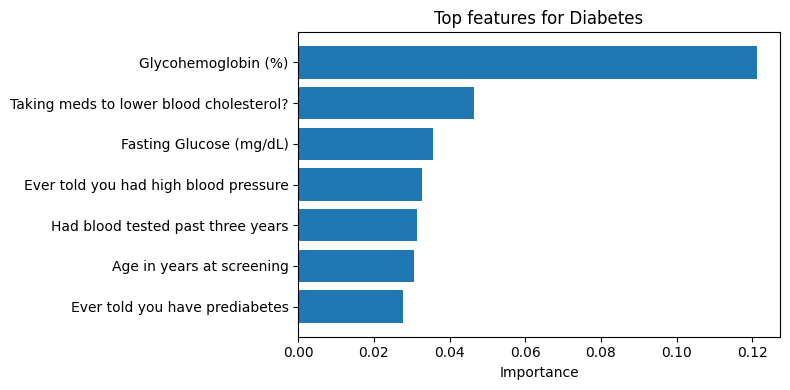

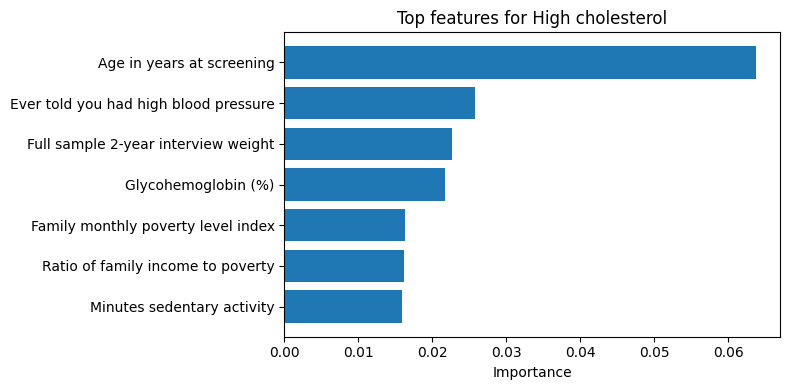

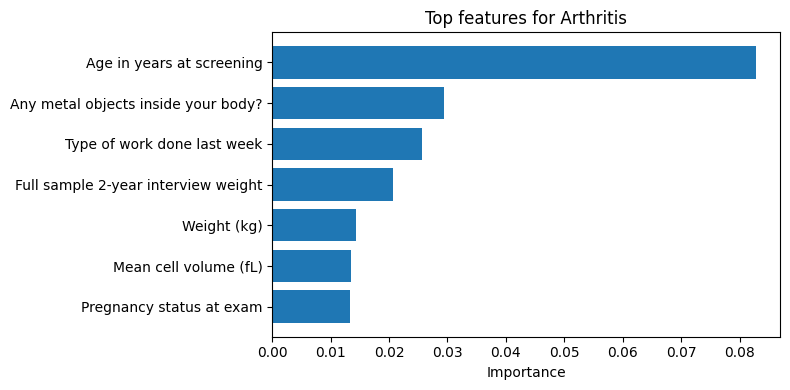

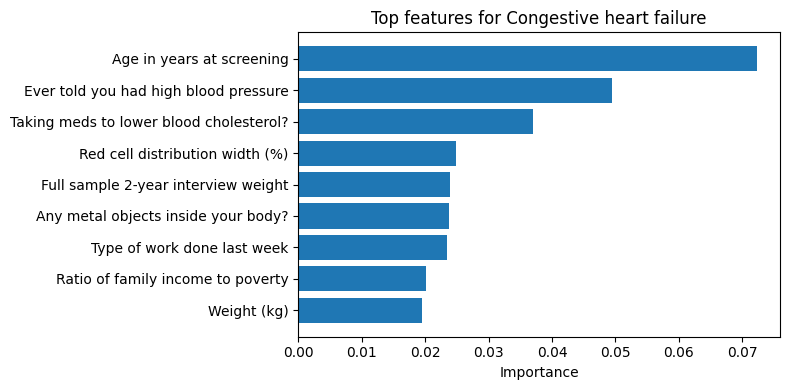

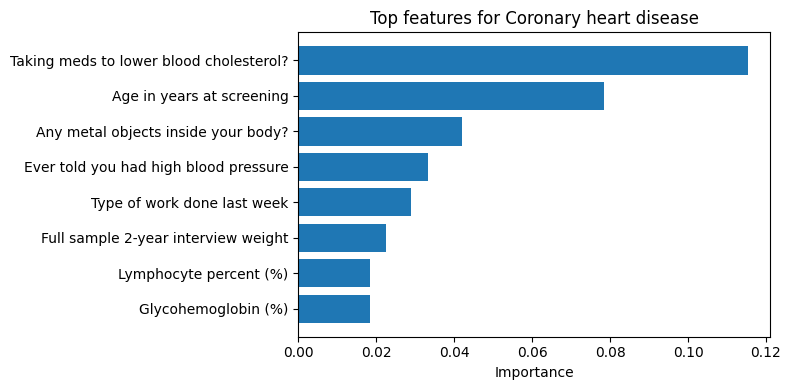

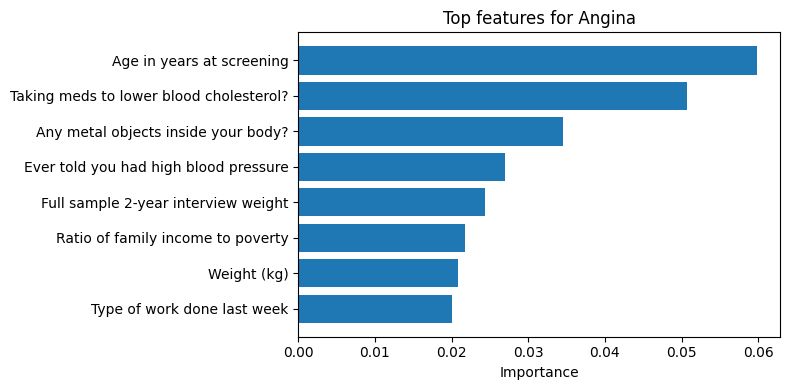

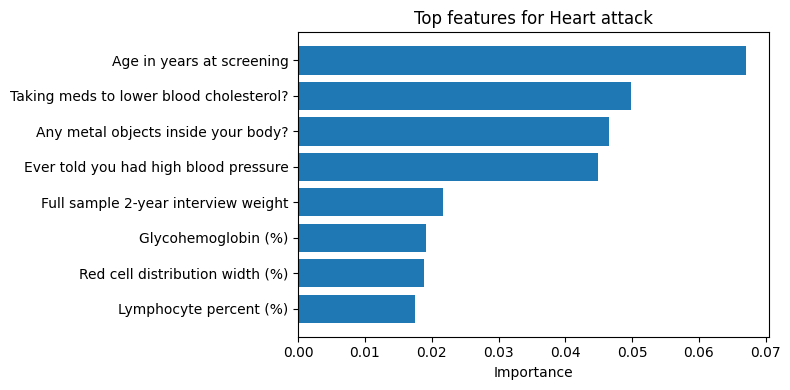

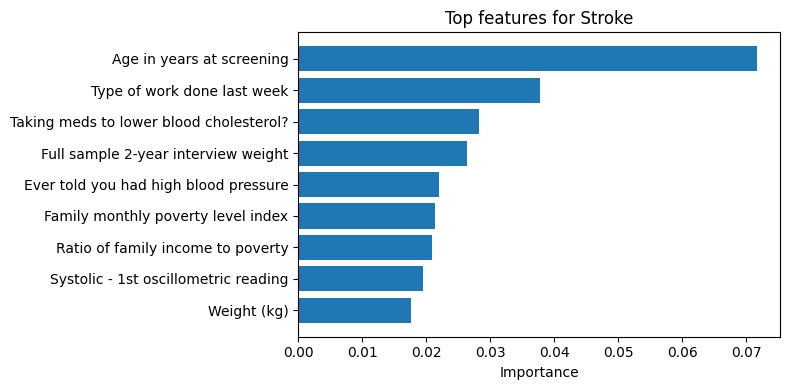

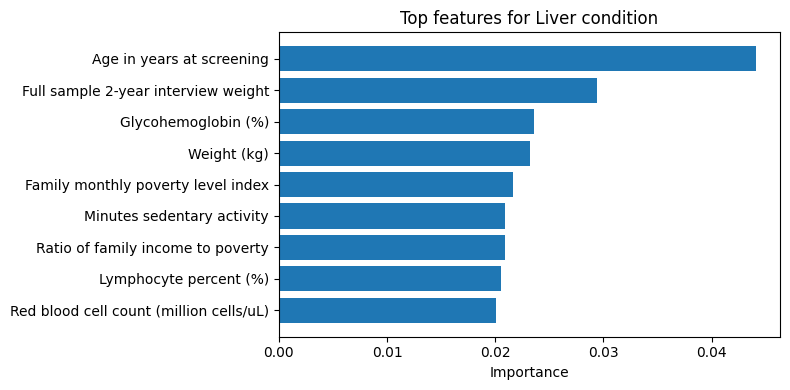

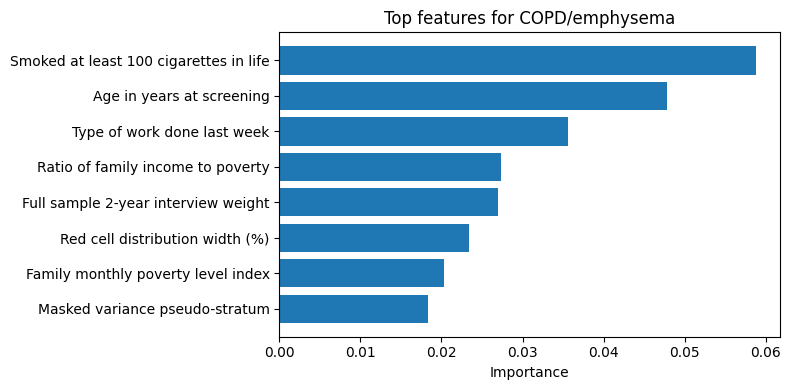

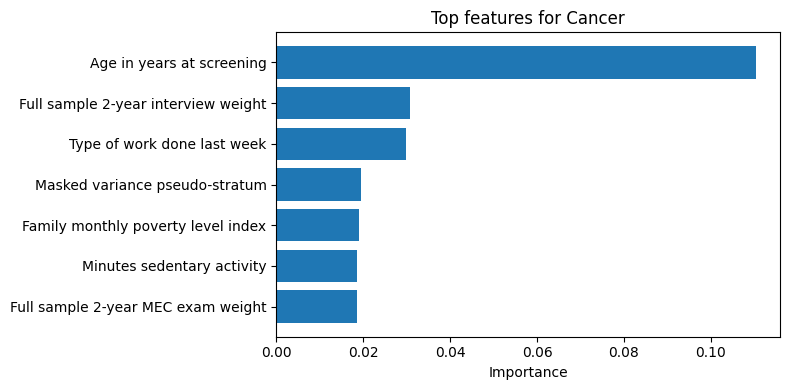

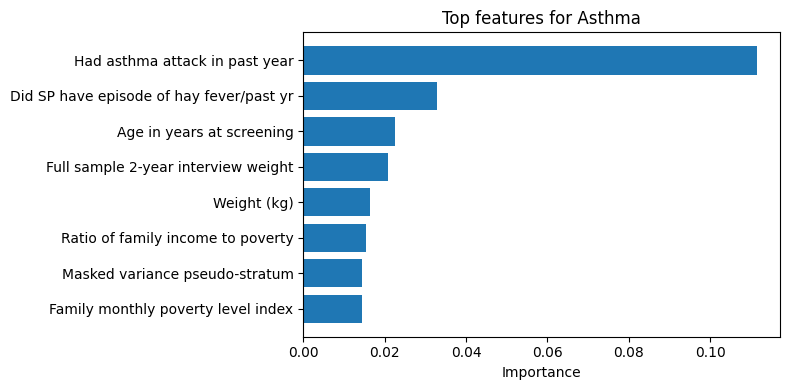

In [25]:
import matplotlib.pyplot as plt

def plot_top_feats(df, top_n=10):
    diseases = df['disease'].unique()

    for disease in diseases:
        subset = df[df['disease'] == disease].dropna(subset=['feature']).sort_values(by='importance', ascending=True)

        top_feats = (
            subset.sort_values(by='importance', ascending=False)
            .head(3)['feature']
            .fillna("Unknown")  
        )
        desc = [str(feat) for feat in top_feats]

        plt.figure(figsize=(8, 4))
        plt.barh(subset['feature'], subset['importance'])
        plt.title(f'Top features for {disease}')
        plt.xlabel('Importance')

        plt.tight_layout()
        plt.show()


plot_top_feats(filtered_fi)


### Additional data visualizations

### 1. Correlation heatmap between diseases  
- are some diseases co-occuring frequently?

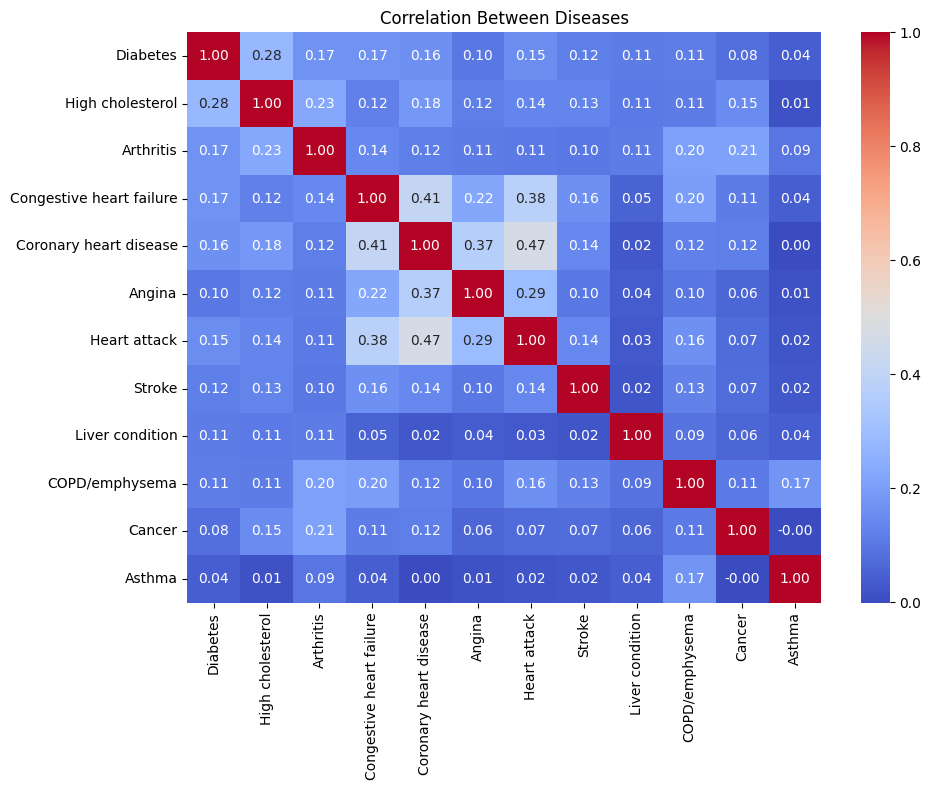

In [26]:
import seaborn as sns

#  correlation matrix
y_labeled = y.rename(columns=disease_label_map)
disease_corr = y_labeled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(disease_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Diseases")
plt.tight_layout()
plt.show()

In [27]:
# upper triangle mask
mask = np.triu(np.ones(disease_corr.shape), k=1).astype(bool)
corr_pairs = disease_corr.where(mask).stack().reset_index()
corr_pairs.columns = ['Disease 1', 'Disease 2', 'Correlation']
corr_pairs = corr_pairs.sort_values(by='Correlation', ascending=False)

# top correlated diseases
print("Top correlated disease pairs:\n")
for _, row in corr_pairs.head(10).iterrows():
    print(f"{row['Disease 1']} ↔ {row['Disease 2']} : Correlation = {row['Correlation']:.2f}")


Top correlated disease pairs:

Coronary heart disease ↔ Heart attack : Correlation = 0.47
Congestive heart failure ↔ Coronary heart disease : Correlation = 0.41
Congestive heart failure ↔ Heart attack : Correlation = 0.38
Coronary heart disease ↔ Angina : Correlation = 0.37
Angina ↔ Heart attack : Correlation = 0.29
Diabetes ↔ High cholesterol : Correlation = 0.28
High cholesterol ↔ Arthritis : Correlation = 0.23
Congestive heart failure ↔ Angina : Correlation = 0.22
Arthritis ↔ Cancer : Correlation = 0.21
Arthritis ↔ COPD/emphysema : Correlation = 0.20


### 2. top global predictive features across all diseases

- which features are the most clinically meaningful?

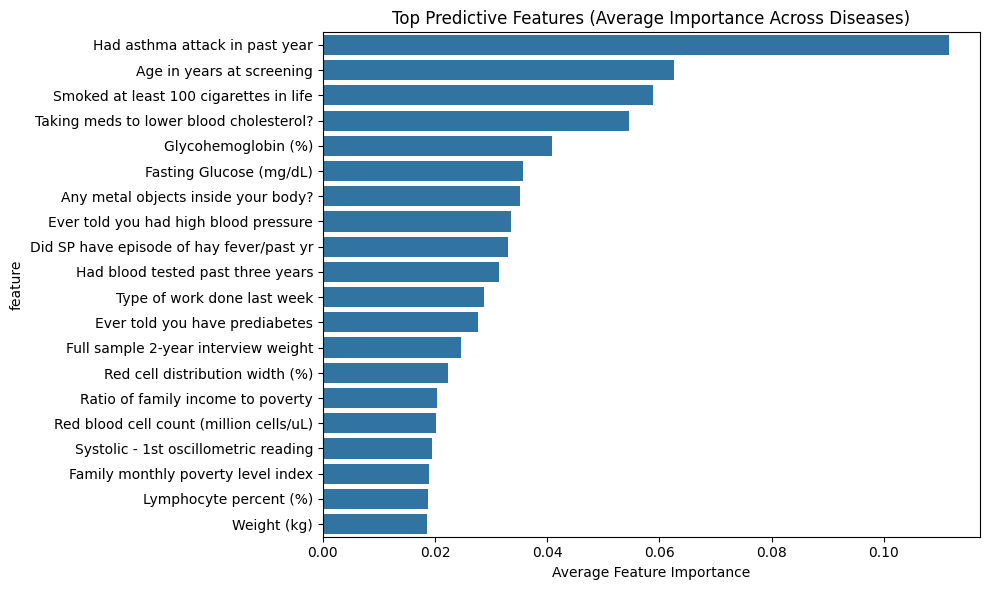

In [28]:
top_feats_overall = (
    filtered_fi.groupby('feature')['importance']
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_feats_overall.values, y=top_feats_overall.index)
plt.title("Top Predictive Features (Average Importance Across Diseases)")
plt.xlabel("Average Feature Importance")
plt.tight_layout()
plt.show()


### 3. Biggest red flag health indicators
- features that are most strongly correlated with many diseases

In [29]:
combined = pd.concat([X, y], axis=1)
corr_matrix = combined.corr().abs()

# for each feature in X, compute its average correlation with all diseases in y
feature_corr_to_diseases = corr_matrix.loc[X.columns, y.columns]

avg_corr = feature_corr_to_diseases.mean(axis=1).sort_values(ascending=False)


In [30]:
label_map = pd.read_csv("sas_labels.csv").set_index("Variable")

avg_corr_df = avg_corr.reset_index()
avg_corr_df.columns = ["Feature", "Avg Correlation"]
avg_corr_df["SAS Label"] = avg_corr_df["Feature"].map(label_map["SAS label"])

print(avg_corr_df.head(20))

      Feature  Avg Correlation                                 SAS Label
0    RIDAGEYR         0.210496                 Age in years at screening
1      RXQ050         0.191987    Number of prescription medicines taken
2      BPQ020         0.158355     Ever told you had high blood pressure
3      OCD150         0.157454               Type of work done last week
4     BPQ101D         0.156086   Taking meds to lower blood cholesterol?
5      RXQ033         0.150189   Taken prescription medicine, past month
6       LBXGH         0.128528                       Glycohemoglobin (%)
7      DIQ070         0.120709  Take diabetic pills to lower blood sugar
8      OSQ230         0.101393       Any metal objects inside your body?
9      MCQ195         0.100153           Which type of arthritis was it?
10   WTINT2YR         0.089136       Full sample 2-year interview weight
11     SMQ020         0.084035    Smoked at least 100 cigarettes in life
12     LBXRDW         0.073168           Red cell d

### 4. Which diseases are easiest/hardest to predict?
- using F1 score

In [31]:
from sklearn.metrics import f1_score

#  per-disease F1 scores
f1_scores = {}

for col in y_test.columns:
    score = f1_score(y_test[col], y_pred_tuned[col], zero_division=0)
    f1_scores[col] = score

f1_named = {
    disease_label_map[col]: score
    for col, score in f1_scores.items()
}

f1_df = pd.DataFrame.from_dict(f1_named, orient='index', columns=['F1 Score'])
f1_df = f1_df.sort_values(by='F1 Score', ascending=False)

print(" Diseases Ranked by F1 Score (Best to Worst):\n")
print(f1_df)

 Diseases Ranked by F1 Score (Best to Worst):

                          F1 Score
Diabetes                  0.814480
Asthma                    0.805369
Arthritis                 0.748869
High cholesterol          0.725070
Cancer                    0.371041
Coronary heart disease    0.294574
Congestive heart failure  0.288889
COPD/emphysema            0.242775
Heart attack              0.233010
Angina                    0.203390
Stroke                    0.201835
Liver condition           0.142857


### 5. Accuracy summaries

In [32]:
from sklearn.metrics import (
    classification_report,
    hamming_loss,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

summary_data = []

for col in y_test.columns:
    precision = precision_score(y_test[col], y_pred_tuned[col], zero_division=0)
    recall = recall_score(y_test[col], y_pred_tuned[col], zero_division=0)
    f1 = f1_score(y_test[col], y_pred_tuned[col], zero_division=0)
    summary_data.append((disease_label_map[col], precision, recall, f1))

eval_summary_df = pd.DataFrame(
    summary_data,
    columns=['Disease', 'Precision', 'Recall', 'F1 Score']
).sort_values(by='F1 Score', ascending=False)

overall_hamming = hamming_loss(y_test, y_pred_tuned)
overall_f1_macro = f1_score(y_test, y_pred_tuned, average='macro')
overall_f1_micro = f1_score(y_test, y_pred_tuned, average='micro')
exact_match_accuracy = accuracy_score(y_test, y_pred_tuned)

print("Per-Disease Evaluation Metrics:\n")
display(eval_summary_df.round(3))

print("\n Overall Evaluation Metrics:")
print(f"Hamming Loss:         {overall_hamming:.4f}")
print(f"Macro F1 Score:       {overall_f1_macro:.4f}")
print(f"Micro F1 Score:       {overall_f1_micro:.4f}")
print(f"Exact Match Accuracy: {exact_match_accuracy:.4f}")


Per-Disease Evaluation Metrics:



,Disease,Precision,Recall,F1 Score
0,Diabetes,0.989,0.692,0.814
11,Asthma,1.000,0.674,0.805
2,Arthritis,0.844,0.673,0.749
1,High cholesterol,0.866,0.623,0.725
10,Cancer,0.383,0.360,0.371
4,Coronary heart disease,0.388,0.238,0.295
3,Congestive heart failure,0.394,0.228,0.289
9,COPD/emphysema,0.323,0.194,0.243
6,Heart attack,0.218,0.250,0.233
5,Angina,0.207,0.200,0.203



 Overall Evaluation Metrics:
Hamming Loss:         0.0946
Macro F1 Score:       0.4227
Micro F1 Score:       0.5945
Exact Match Accuracy: 0.4304


per disease evaluation metrics:  
- diabetes, asthma, arthritis, high cholesterol have very good F1 scores, meaning they are easier to detect with high precision and recall.
-  cancer and CHD/CHF were mid tier diseases with F1 scores of 0.295 to 0.371. This is okay, cancer is very heterogenous and CHD/CHF have lots of overlap and shared risk.
- low tier diseases with F1 scores of <0.25 were harder to predict. COPD was likely underrepresented and/or hard to separate from asthma without more data. Heart attacks don't leave clear survey footprints if they arent recent or well treated. Angina is often underreported and overlaps a lot with CHD making it more difficult to detect. Strokes are less accurate likely due to indirect features. Finally, liver condition is likely a very noisy label and have weak signals in the NHANES features.

overall evaluation metrics
- hamming loss: lower is better. 1-0.946 = 0.09 --> 91% of individual labels are correct. This is good
- Macro F1 score: some diseases drive this down as explained above. This is typical for imabalanced multi-label data.
- Micro F1 score: Capturing the majority of correct disease cases overall. The model is learning well.
- Exact match frequency: how often all 12 labels for a person are entirely correct. This is strict, even 1 wrong label = 0. 43% means we are perfectly predicting all 12 diseases for 43% of patients, which is very good.